In [2]:
from itertools import chain
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math
from typing import List, Tuple, Dict, Optional
from torch.utils.tensorboard import SummaryWriter

import base64
import requests
import os

from pathlib import Path

## Hyper-Parameters

In [3]:
GH_TOKEN = ""

MODEL_NAME = "TestV1"
EPOCHS = 10


FILE_NAME = "spa"
BATCH_SIZE = 32
LAYERS = 3
EMB_SIZE = 256
HEADS = 8

## Get Environment variables

In [4]:
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

IS_COLAB = is_running_in_colab()

In [5]:
DEVICE = 'cuda' if IS_COLAB else 'cpu'

## Data file

In [6]:
def get_text_path(file_name: str):
    if IS_COLAB:
        url = f"https://raw.githubusercontent.com/WillCable97/HomemadeTransformer/main/data/raw/{file_name}.txt"
        !wget {url}
        return f"./{file_name}.txt"
    else:
        from homemadetransformer.config import DATA_DIR
        return DATA_DIR / "raw" / f"{file_name}.txt"

## Simple Word Tokenizer

In [7]:
class SimpleWordTokenizer:
    """Simple word-based tokenizer that splits on whitespace."""
    
    def __init__(self, sos_token="<SOS>", eos_token="<EOS>", pad_token="<PAD>", unk_token="<UNK>"):
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.unk_token = unk_token
        
    def tokenize(self, text: str) -> List[str]:
        """Tokenize text by splitting on whitespace."""
        return text.lower().strip().split()
    
    def add_special_tokens(self, tokens: List[str]) -> List[str]:
        """Add SOS and EOS tokens to a sequence."""
        return [self.sos_token] + tokens + [self.eos_token]


## Preprocessor

In [8]:
class TranslationPreprocessor:
    """Preprocessor for translation datasets with configurable tokenization."""
    
    def __init__(self, 
                 src_tokenizer=None, 
                 tgt_tokenizer=None,
                 max_src_len: Optional[int] = None,
                 max_tgt_len: Optional[int] = None):
        """
        Initialize the preprocessor.
        
        Args:
            src_tokenizer: Tokenizer for source language (defaults to SimpleWordTokenizer)
            tgt_tokenizer: Tokenizer for target language (defaults to SimpleWordTokenizer)
            src_lang: Source language code
            tgt_lang: Target language code
            max_src_len: Maximum source sequence length (None for auto)
            max_tgt_len: Maximum target sequence length (None for auto)
        """
        self.src_tokenizer = src_tokenizer or SimpleWordTokenizer()
        self.tgt_tokenizer = tgt_tokenizer or SimpleWordTokenizer()
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len
        
        # Vocabulary mappings
        self.src_vocab = {}
        self.tgt_vocab = {}
        self.src_vocab_to_idx = {}
        self.tgt_vocab_to_idx = {}
        self.src_idx_to_vocab = {}
        self.tgt_idx_to_vocab = {}
        
        # Statistics
        self.src_vocab_size = 0
        self.tgt_vocab_size = 0
        self.max_src_len_actual = 0
        self.max_tgt_len_actual = 0
        
    def clean_translation_pair(self, line: str) -> Optional[Tuple[str, str]]:
        """Clean a translation pair from the dataset."""
        parts = line.strip().split("\t")
        
        if len(parts) < 2:
            return None
            
        src_text = parts[0].strip()
        tgt_text = parts[1].strip().split("CC-BY")[0].strip()  # Remove attribution text
        
        return src_text, tgt_text
    
    def build_vocabularies(self, src_sentences: List[str], tgt_sentences: List[str]):
        """Build vocabulary mappings from tokenized sentences."""
        # Tokenize all sentences
        src_tokenized = [self.src_tokenizer.add_special_tokens(self.src_tokenizer.tokenize(sent)) 
                        for sent in src_sentences]
        tgt_tokenized = [self.tgt_tokenizer.add_special_tokens(self.tgt_tokenizer.tokenize(sent)) 
                        for sent in tgt_sentences]
        
        # Build source vocabulary
        src_vocab = set(chain.from_iterable(src_tokenized))
        self.src_vocab_to_idx = {word: i for i, word in enumerate(src_vocab)}
        self.src_idx_to_vocab = {i: word for word, i in self.src_vocab_to_idx.items()}
        self.src_vocab_size = len(src_vocab)
        
        # Build target vocabulary
        tgt_vocab = set(chain.from_iterable(tgt_tokenized))
        self.tgt_vocab_to_idx = {word: i for i, word in enumerate(tgt_vocab)}
        self.tgt_idx_to_vocab = {i: word for word, i in self.tgt_vocab_to_idx.items()}
        self.tgt_vocab_size = len(tgt_vocab)
        
        # Calculate max lengths
        self.max_src_len_actual = max(len(s) for s in src_tokenized)
        self.max_tgt_len_actual = max(len(s) for s in tgt_tokenized)
        
        # Use provided max lengths if specified
        if self.max_src_len is not None:
            self.max_src_len_actual = min(self.max_src_len_actual, self.max_src_len)
        if self.max_tgt_len is not None:
            self.max_tgt_len_actual = min(self.max_tgt_len_actual, self.max_tgt_len)
            
        return src_tokenized, tgt_tokenized
    
    def encode_sentence(self, sentence: List[str], vocab_to_idx: Dict[str, int]) -> List[int]:
        """Encode a tokenized sentence to indices."""
        return [vocab_to_idx.get(word, vocab_to_idx.get(self.src_tokenizer.unk_token, 0)) 
                for word in sentence]
    
    def pad_sequence(self, seq: List[int], max_len: int, pad_idx: int = 0) -> List[int]:
        """Pad a sequence to the specified length."""
        return seq + [pad_idx] * (max_len - len(seq))
    
    def preprocess_data(self, raw_data: List[str]) -> Tuple[List[List[int]], List[List[int]]]:
        """
        Preprocess raw translation data.
        
        Args:
            raw_data: List of tab-separated translation pairs
            
        Returns:
            Tuple of (encoded_src_sentences, encoded_tgt_sentences)
        """
        # Clean the data
        clean_pairs = [self.clean_translation_pair(line) for line in raw_data]
        clean_pairs = [pair for pair in clean_pairs if pair is not None]
        
        # Split into source and target
        src_sentences = [pair[0] for pair in clean_pairs]
        tgt_sentences = [pair[1] for pair in clean_pairs]
        
        # Build vocabularies and tokenize
        src_tokenized, tgt_tokenized = self.build_vocabularies(src_sentences, tgt_sentences)
        
        # Encode sentences
        src_encoded = [self.encode_sentence(sent, self.src_vocab_to_idx) for sent in src_tokenized]
        tgt_encoded = [self.encode_sentence(sent, self.tgt_vocab_to_idx) for sent in tgt_tokenized]
        
        # Pad sequences
        src_padded = [self.pad_sequence(sent, self.max_src_len_actual) for sent in src_encoded]
        tgt_padded = [self.pad_sequence(sent, self.max_tgt_len_actual) for sent in tgt_encoded]
        
        return src_padded, tgt_padded
    
    def get_vocab_info(self) -> Dict:
        """Get vocabulary information."""
        return {
            'src_vocab_size': self.src_vocab_size,
            'tgt_vocab_size': self.tgt_vocab_size,
            'max_src_len': self.max_src_len_actual,
            'max_tgt_len': self.max_tgt_len_actual,
            'src_vocab_to_idx': self.src_vocab_to_idx,
            'tgt_vocab_to_idx': self.tgt_vocab_to_idx,
            'src_idx_to_vocab': self.src_idx_to_vocab,
            'tgt_idx_to_vocab': self.tgt_idx_to_vocab
        }


## Full dataset object

In [9]:
class TranslationDataset(Dataset):
    """PyTorch Dataset for translation data."""
    
    def __init__(self, src_data: List[List[int]], tgt_data: List[List[int]]):
        self.src_data = src_data
        self.tgt_data = tgt_data
        
    def __len__(self):
        return len(self.src_data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.src_data[idx]), torch.tensor(self.tgt_data[idx])


## Standard Model

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -math.log(10000.0) / d_model)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])


In [11]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead,
                 src_vocab_size, tgt_vocab_size, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout)

        self.transformer = nn.Transformer(d_model=emb_size, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask, src_pad_mask, tgt_pad_mask, mem_pad_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        out = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask,
                               None, src_pad_mask, tgt_pad_mask, mem_pad_mask)
        return self.generator(out)


In [12]:
def generate_square_subsequent_mask(sz, device):
    return torch.triu(torch.full((sz, sz), float('-inf'), device=device), 1)

def create_mask(src, tgt, pad_idx=0):
    src_seq_len = src.size(0)
    tgt_seq_len = tgt.size(0)
    device = src.device  # assume both src and tgt are on the same device

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == pad_idx).transpose(0, 1)
    tgt_padding_mask = (tgt == pad_idx).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Training loop

In [19]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, pad_idx=0, device='cpu'):
    model.to(device)
    model.train()
    losses = []

    writer = torch.utils.tensorboard.SummaryWriter(f'runs/{MODEL_NAME}')
    

    for epoch in range(num_epochs):
        total_loss = 0
        print(f"Starting epoch {epoch}")
        dl_len = len(dataloader)
        i = 1

        for eng_batch, spa_batch in dataloader:
            print(f"\rStarting {i}/{dl_len}", end="")
            i += 1
            eng_batch = eng_batch.transpose(0, 1).to(device) 
            spa_batch = spa_batch.transpose(0, 1).to(device) 

            tgt_input = spa_batch[:-1, :]
            tgt_output = spa_batch[1:, :]

            src_mask, tgt_mask, src_pad_mask, tgt_pad_mask = create_mask(eng_batch, tgt_input, pad_idx)

            logits = model(
                eng_batch,
                tgt_input,
                src_mask,
                tgt_mask,
                src_pad_mask,
                tgt_pad_mask,
                src_pad_mask  # memory padding mask
            )

            optimizer.zero_grad()

            # Flatten predictions and targets
            logits_flat = logits.reshape(-1, logits.shape[-1])
            tgt_output_flat = tgt_output.reshape(-1)

            loss = loss_fn(logits_flat, tgt_output_flat)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
            writer.add_scalar('Loss/train', loss.item(), epoch)
        

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs} — Loss: {avg_loss:.4f}")
        
        losses.append(avg_loss)

    writer.close()
    os.makedirs('./models', exist_ok=True)
    torch.save(model.state_dict(), f'./models/{MODEL_NAME}.pth')

    return losses

    


## Create Instances

In [17]:
#Data

text_path = get_text_path(FILE_NAME)

with open(text_path, encoding="utf-8") as f:
    lines = f.read().strip().split("\n")[:1000]

preprocessor = TranslationPreprocessor(
    src_tokenizer=SimpleWordTokenizer(),
    tgt_tokenizer=SimpleWordTokenizer()
)

src_data, tgt_data = preprocessor.preprocess_data(lines)
dataset = TranslationDataset(src_data, tgt_data)
dl = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

src_vocab_size = preprocessor.src_vocab_size
tgt_vocab_size = preprocessor.tgt_vocab_size

## Github interact

In [ ]:
def upload_to_github(local_path, repo_path, token, username="WillCable97", repo="HomemadeTransformer", branch="main"):
    
    with open(local_path, "rb") as f:
        content = base64.b64encode(f.read()).decode("utf-8")

    url = f"https://api.github.com/repos/{username}/{repo}/contents/{repo_path}"
    data = {
        "message": f"Upload {repo_path} from Colab",
        "content": content,
        "branch": branch
    }
    headers = {"Authorization": f"token {token}"}
    r = requests.put(url, headers=headers, json=data)
    if r.status_code == 201:
        print(f"✅ Uploaded {repo_path} to GitHub")
    else:
        print(f"❌ Failed to upload {repo_path} — {r.status_code}: {r.json()}")

## Training

In [18]:
#Model
model = Seq2SeqTransformer(
    num_encoder_layers=LAYERS,
    num_decoder_layers=LAYERS,
    emb_size=EMB_SIZE,
    nhead=HEADS,
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

# Train it
losses = train_model(model, dl, optimizer, loss_fn, num_epochs=EPOCHS, pad_idx=0, device=DEVICE)

if IS_COLAB:
    #Save Log file
    log_dir= Path(F"./runs/{MODEL_NAME}")
    latest_event_file = max(log_dir.glob("events.out.tfevents.*"), key=lambda f: f.stat().st_mtime, default=None)
    upload_to_github(latest_event_file,
                      f"./notebooks/runs/{MODEL_NAME}/{latest_event_file.name}"
                      , GH_TOKEN)
    
    #Do the model
    upload_to_github(f"./models/{MODEL_NAME}.pth",
                      f"./notebooks/models/{MODEL_NAME}.pth"
                      , GH_TOKEN)

c:\Users\willi\Desktop\AIPortfolio\HomemadeTransformer\venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
c:\Users\willi\Desktop\AIPortfolio\HomemadeTransformer\venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Starting epoch 0
Starting 32/32Epoch 1/10 — Loss: 5.0918
Starting epoch 1
Starting 32/32Epoch 2/10 — Loss: 4.5318
Starting epoch 2
Starting 32/32Epoch 3/10 — Loss: 4.2425
Starting epoch 3
Starting 32/32Epoch 4/10 — Loss: 3.8748
Starting epoch 4
Starting 32/32Epoch 5/10 — Loss: 3.5315
Starting epoch 5
Starting 32/32Epoch 6/10 — Loss: 3.2472
Starting epoch 6
Starting 32/32Epoch 7/10 — Loss: 3.0047
Starting epoch 7
Starting 32/32Epoch 8/10 — Loss: 2.7472
Starting epoch 8
Starting 32/32Epoch 9/10 — Loss: 2.5391
Starting epoch 9
Starting 32/32Epoch 10/10 — Loss: 2.3051
Model weights saved to model_weights.pth


In [29]:
latest_event_file.name

'events.out.tfevents.1751837683.Wills_PC.16068.3'

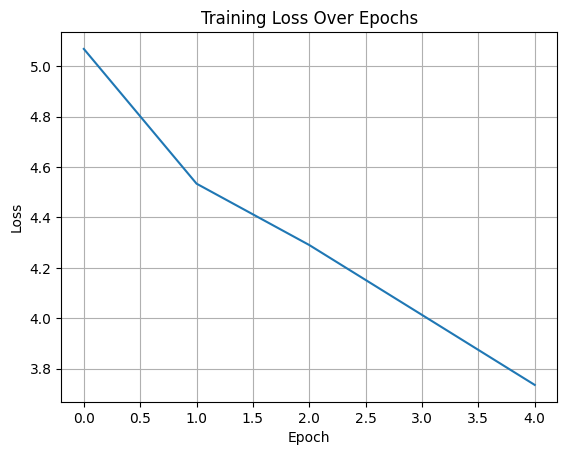

In [18]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
def greedy_decode(model, src_sentence, src_vocab, tgt_vocab, ind_to_word_spa, max_len=50, device='cuda'):
    model.eval()

    sos_token = tgt_vocab["<SOS>"]
    eos_token = tgt_vocab["<EOS>"]
    pad_token = tgt_vocab.get("<PAD>", 0)

    # Encode source sentence
    tokens = ["<SOS>"] + src_sentence.lower().strip().split() + ["<EOS>"]
    src_indices = [src_vocab.get(tok, src_vocab.get("<UNK>", 0)) for tok in tokens]
    src_tensor = torch.tensor(src_indices).unsqueeze(1).to(device)  # [seq_len, 1]
    src_mask = torch.zeros((src_tensor.size(0), src_tensor.size(0)), device=device).type(torch.bool)

    # Encoder output
    src_emb = model.positional_encoding(model.src_tok_emb(src_tensor))
    memory = model.transformer.encoder(src_emb, src_mask)

    # Start decoding with <SOS>
    tgt_indices = [sos_token]
    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_indices).unsqueeze(1).to(device)
        tgt_mask = generate_square_subsequent_mask(tgt_tensor.size(0), 'cuda')#s.to(device)

        tgt_emb = model.positional_encoding(model.tgt_tok_emb(tgt_tensor))
        out = model.transformer.decoder(tgt_emb, memory, tgt_mask)
        out = model.generator(out)

        next_token = out[-1].argmax(-1).item()

        if next_token == eos_token:
            break

        tgt_indices.append(next_token)

    decoded = [ind_to_word_spa.get(idx, "") for idx in tgt_indices[1:]]  # skip SOS
    return " ".join(decoded)


In [ ]:
def translate(eng_sentence, model, src_vocab, tgt_vocab, ind_to_word_spa):
    return greedy_decode(model, eng_sentence, src_vocab, tgt_vocab, ind_to_word_spa)


In [ ]:
print(translate("I'm very excited to have dinner with you", model, vocab_to_ind_eng, vocab_to_ind_spa, ind_to_word_spa))

NameError: name 'translate' is not defined